# **Predicting Fatal Victims of the Titanic Sinking**

Inspired by the notebook of Ravi Ramakrishnan on kaggle. Available [here](https://www.kaggle.com/code/ravi20076/titanic-eda-model-custompipelines)

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from termcolor import colored
import matplotlib.pyplot as plt

In [3]:
from sklearn.ensemble import RandomForestClassifier

## Data Understanding

In [4]:
raw_train = pd.read_csv('./data/train.csv')
raw_test = pd.read_csv('./data/test.csv')

### First look at data

It's possible to perceive that Name, Sex, Ticket, Cabin, and Embarked are all categorical attributes, and they need to be processed

In [3]:
raw_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Dividing training dataset in X, y frames, and printing information about training dataset

The amount of nulls in Cabin, and Age columns is very high. Embarked also has null values

In [49]:
X, y = raw_train.iloc[:, 2:], raw_train['Survived']

print(colored(f'Train dataset length = {len(X)}', color='green', attrs=['bold']))
print(colored(f'Test  dataset length = {len(raw_test)}\n', color='blue', attrs=['bold']))
display(raw_train.info())

Train dataset length = 891
Test  dataset length = 418

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


None

###  Visualizing training dataset description

Fare and Age have a bigger spread on their values 

In [8]:
print(colored(f'Training dataset description\n', color='green', attrs=['bold']))
display(raw_train.describe())

Training dataset description



,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### Null values exploration

Number of NaNs in Cabin, Age and Embarked columns
Age: 177, Cabin: 687, Embarked: 2


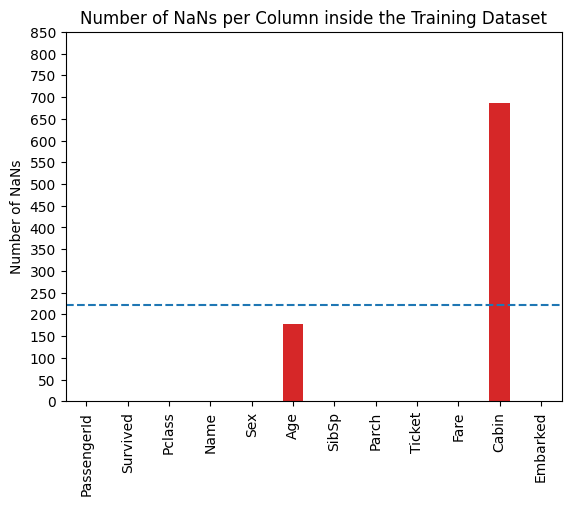

In [48]:
cabin_nans = raw_train['Cabin'].isna().sum()
age_nans   = raw_train['Age'].isna().sum()
embarked_nans = raw_train['Embarked'].isna().sum()

print(colored(f'Number of NaNs in Cabin, Age and Embarked columns', color='red', attrs=['bold']))
print(colored(f'Age: {age_nans}, Cabin: {cabin_nans}, Embarked: {embarked_nans}', color='red', attrs=['bold']))

# barplot of cabin_nans and age_nans
_ = raw_train.isna().sum()
ax = _.plot.bar(color='tab:red')
ax.set_ylabel('Number of NaNs')
ax.set_yticks(range(0, 900, 50))
ax.axhline(y=len(raw_train)/4, color='tab:blue', linestyle='--')
ax.set_title('Number of NaNs per Column inside the Training Dataset')
plt.show()

The nan values are so prevalent, that the entries cannot be simply deleted from the dataset. A different approach is necessary. For that reason, a data enrichment inference will be applied over fare. The fare, is the amount paid by the passenger, and is directly related to Cabin, and Class features.

### Target exploration

Influence of Age, and Class, on Survival probability



Text(0, 0.5, 'Survival Rate')

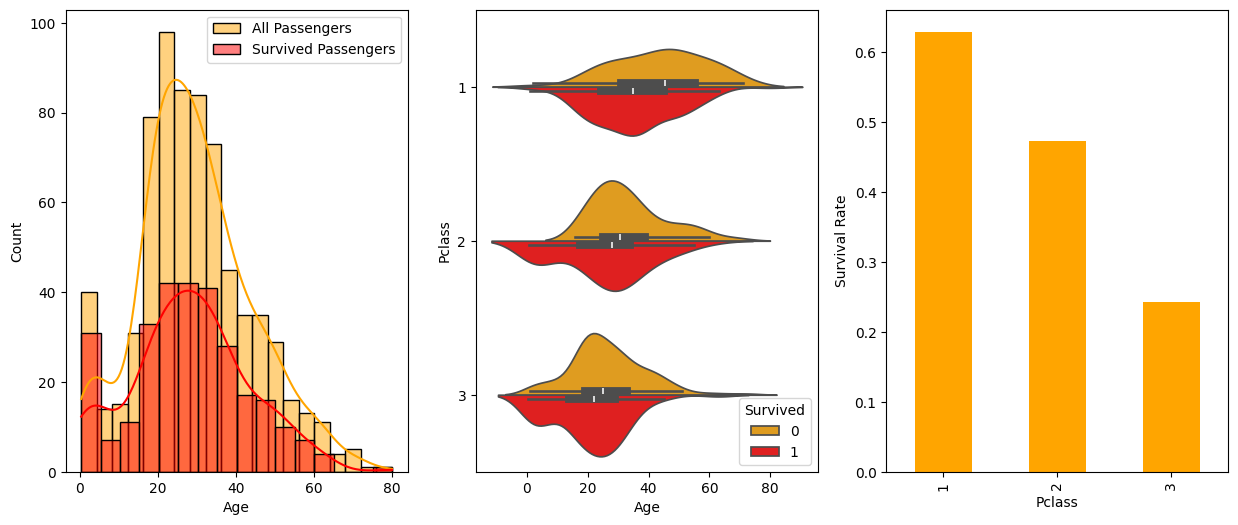

In [48]:
# Filter the survived and non-survived passengers

fig, ax = plt.subplots(1, 3, figsize=(15, 6))
print(colored(f'Influence of Age, and Class, on Survival probability\n', color='green', attrs=['bold']))

_ = raw_train[['Age', 'Survived', 'Pclass']]
_ = _[_['Survived'] == 1]

sns.histplot(data=raw_train, x='Age', kde=True, color='orange', ax=ax[0], label='All Passengers')
sns.histplot(data=_, x='Age', kde=True, color='red', ax=ax[0], label='Survived Passengers')
ax[0].legend()
sns.violinplot(data=raw_train, x='Age', y='Pclass', palette='blend:orange,red', hue='Survived', split=True, ax=ax[1], orient='h')

_ = raw_train.groupby('Pclass')['Survived'].mean()
ax[2] = _.plot.bar(color='orange')
ax[2].set_ylabel('Survival Rate')

Average Fare per Class


Pclass
1    84.154687
2    20.662183
3    13.675550
Name: Fare, dtype: float64

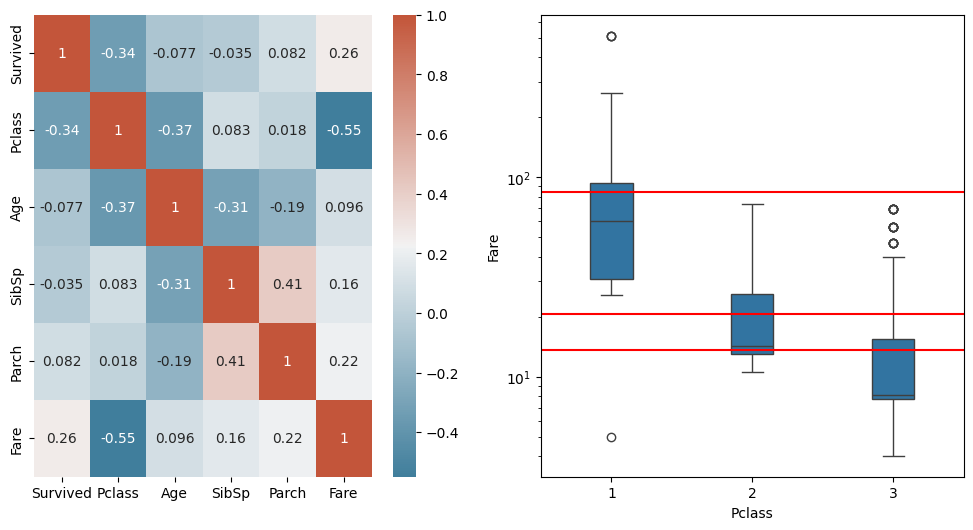

In [77]:
corr = raw_train.drop(['Name', 'Ticket', 'Embarked', 'Cabin', 'Sex', 'PassengerId'], axis=1).corr()
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, cmap=cmap, annot=True, ax=ax[0])

sns.boxplot(x = raw_train['Pclass'], y= raw_train['Fare'], ax=ax[1], log_scale=True, width=0.3)
_ = raw_train.groupby('Pclass')['Fare'].mean()
print(colored(f'Average Fare per Class', color='green', attrs=['bold']))
display(_)
ax[1].axhline(y=_[1], color='red')
ax[1].axhline(y=_[2], color='red')
ax[1].axhline(y=_[3], color='red')

plt.show()

### Age Inference by Fare and Class

## Data Preparation

In [332]:
def dealWithCabin(df):
    
    dft = df.copy()
    dft['Numeration'] = dft['Cabin'].str.extract(r'([A-Za-z])(\d+)', expand=False)[1].astype(float)
    dft['Numeration'].fillna(0, inplace=True)
    
    dft['Sector'] = dft['Cabin'].str.extract(r'([A-Za-z])(\d+)', expand=False)[0]
    dft['Sector'].fillna('Z', inplace=True)
    dft['Sector'] = dft['Sector'].map({
        'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5,
        'F': 6, 'G': 7, 'T': 8, 'Z': 0
    }).astype(int)

    dft.drop('Cabin', axis=1, inplace=True)
    return dft

In [333]:
def categoricToNumeric(df):
    
    df = df.copy()

    # map categorical values to numeric on 'Embarke' column
    emb = {x: i for i, x in enumerate(df['Embarked'].unique())}
    df['Embarked'] = df['Embarked'].map(emb)

    # map categorical values to numeric on 'Sex' column
    sex = {df['Sex'].unique()[0]: 0, df['Sex'].unique()[1]: 1}
    df['Sex'] = df['Sex'].map(sex)
    
    # remove categorical parts from 'Ticket' column
    df['Ticket'] = df['Ticket'].str.extract('(\d+)', expand=False).astype(float)

    df = dealWithCabin(df)
    return df

In [334]:
def removeNaN(df):
    for column in df:
        if df[column].dtype == 'float64':
            df[column] = df[column].fillna(df[column].mean())
    df.drop(['Name'], axis=1, inplace=True, errors='ignore')
    return df

In [335]:
def normalize (df):
    for column in df:
        if df[column].dtype == 'float64':
            df[column] = (df[column] - df[column].min()) / (df[column].max() - df[column].min())
    return df 

In [336]:
# def a DataPreparation that assemble all the data preparation processes done to raw_train until now

def DataPreparation(df):
    a = df.copy()
    a = categoricToNumeric(a)
    a = removeNaN(a)
    a = normalize(a)
    return a

X_norm = DataPreparation(X)
X_norm.describe()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Numeration,Sector
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,2.308642,0.352413,0.367921,0.523008,0.381594,0.073467,0.062858,0.368126,0.076577,0.756453
std,0.836071,0.477990,0.163383,1.102743,0.806057,0.161648,0.096995,0.647601,0.181855,1.570855
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.271174,0.000000,0.000000,0.003802,0.015440,0.000000,0.000000,0.000000
50%,3.000000,0.000000,0.367921,0.000000,0.000000,0.035601,0.028213,0.000000,0.000000,0.000000
75%,3.000000,1.000000,0.434531,1.000000,0.000000,0.111907,0.060508,1.000000,0.000000,0.000000
max,3.000000,1.000000,1.000000,8.000000,6.000000,1.000000,1.000000,3.000000,1.000000,7.000000


## Modelling

### Random Forest probably plateu, so lets Stack it

In [337]:
rf = RandomForestClassifier(
    n_estimators=50,
    max_depth=6,
    min_samples_split=5,
    min_samples_leaf=2,
)

In [338]:
results = rf.fit(X_norm, raw_train['Survived'])

In [339]:
# validate predictions of results against X_base and save the results to score variable
def validate_model(model, df):
    return model.score(df.drop('Survived', axis=1), df['Survived'])

X_base = X_norm.copy()
X_base['Survived'] = y
score = validate_model(results, X_base)

In [340]:
print(score)

0.8832772166105499


## Evaluation

In [341]:
X_test = raw_test.iloc[:, 1:]
X_test = DataPreparation(X_test)
X_test.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Numeration,Sector
0,3,0,0.452723,0,0,0.106700,0.015282,0,0.0,0
1,3,1,0.617566,1,0,0.117134,0.013663,1,0.0,0
2,2,0,0.815377,0,0,0.077475,0.018909,0,0.0,0
3,3,0,0.353818,0,0,0.101619,0.016908,1,0.0,0
4,3,1,0.287881,1,1,0.999995,0.023984,1,0.0,0


In [342]:
# predict the results of X_test and save it to predictions variable
predictions = results.predict(X_test)

# save predictions to a csv file
df_predictions = pd.DataFrame({'PassengerId': raw_test['PassengerId'], 'Survived': predictions.astype(int)})
df_predictions.to_csv('predictions.csv', index=False)